In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import jax
import jax.numpy as jnp
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.efm as exp_efm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load EFM results

In [23]:
data_res = pickle.load(open("../data/efm/efm_hmc_n3000_seed0.pkl", "rb"))

In [25]:
states = np.stack([xx[0] for xx in data_res["state"]], 0)

In [26]:
states.shape

(3000, 5)

In [81]:
true_params = np.array([-1., 0])

efm = exp_efm.EFM(true_params)

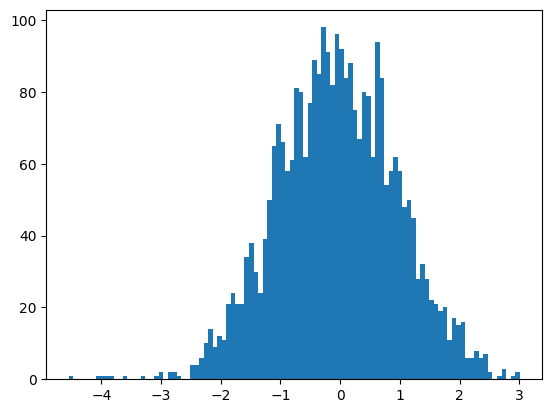

In [40]:
_ = plt.hist(states[:, 4], bins=100)

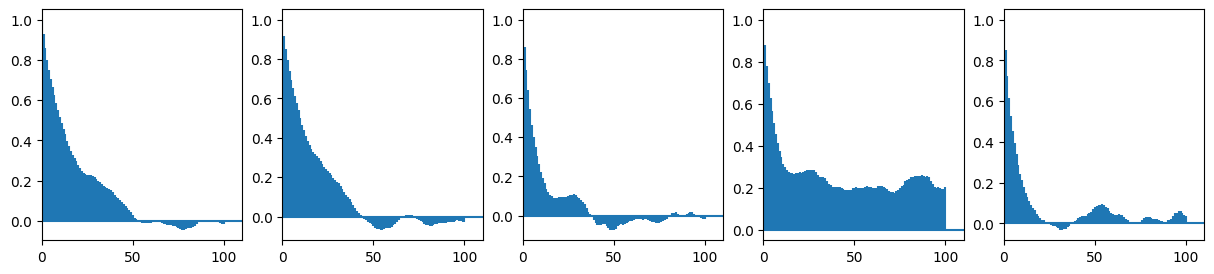

In [53]:
_, axes = plt.subplots(ncols=5, figsize=(15, 3))
for i, ax in enumerate(axes.flatten()):
    ax.acorr(states[:, i], maxlags = 100)
    ax.set_xlim(0.)

In [86]:
X = states[::50]
efm.sm_est(X)

Array([-1.0587883 ,  0.03012102], dtype=float32)

In [217]:
np.random.seed(2024)

efm = exp_efm.EFM(np.zeros((2,)))
X = efm.sample(1000)
kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
efm.ksd_est(X, kernel)

/home/clustor/ma/x/xl6116/research/robust-kernel-test/experiments/efm.py:69: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return x


Array([ 0.02641327, -0.00542635], dtype=float32)

In [218]:
np.random.seed(2024)
X_contam = efm.sample_contam(1000, eps=0.05, outlier=10. * np.ones((5,)))
kernel = kernels.IMQ(med_heuristic=True, X=X_contam, Y=X_contam)
efm.ksd_est(X_contam, kernel)

Array([0.30054438, 0.29845858], dtype=float32)

In [220]:
np.random.seed(2024)
X = efm.sample(5000)
kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
efm.ksd_est(X, kernel)

In [ ]:
efm.sm_est(X)

In [238]:
np.random.seed(2024)
X = efm.sample(200)
kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
est_params = efm.ksd_est(X, kernel)

/home/clustor/ma/x/xl6116/research/robust-kernel-test/experiments/efm.py:69: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return x


In [244]:
# est_efm = exp_efm.EFM(est_params)
est_efm = exp_efm.EFM(np.zeros((2,)))

score, hvp = est_efm.compute_grad_and_hvp(X)

In [223]:
hvp_denom_sup = 1.
X_res = np.expand_dims(X, 0)
score_res = np.expand_dims(score, 0)
hvp_res = np.expand_dims(hvp, 0)

theta = 0.1

In [224]:
res = exp_utils.run_tests(
    samples=X_res, scores=score_res, hvps=hvp_res, hvp_denom_sup=hvp_denom_sup, 
    theta=theta, bw="med", alpha=0.05, verbose=True,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


In [225]:
res["rbf"]

{'nonsq_stat': [Array(0.16259159, dtype=float32)],
 'stat': [Array(0.02643602, dtype=float32)],
 'u_stat': [],
 'pval': [Array(0.65634364, dtype=float32, weak_type=True)],
 'rej': [0],
 'boot_stats': [array([0.02309129, 0.03696243, 0.03051676, 0.03181617, 0.03263012,
         0.02389938, 0.02468866, 0.03978031, 0.03009584, 0.01947895,
         0.02849437, 0.03016425, 0.02288527, 0.02470086, 0.02317857,
         0.01772941, 0.05685254, 0.01679318, 0.02728976, 0.03630476,
         0.03422087, 0.03137206, 0.02511796, 0.035787  , 0.03514912,
         0.02400936, 0.02538567, 0.03270467, 0.0310781 , 0.02944112,
         0.04030979, 0.02804152, 0.02266177, 0.03005852, 0.0311309 ,
         0.03366491, 0.01948159, 0.02829609, 0.03033528, 0.04010079,
         0.02195832, 0.02945221, 0.02692001, 0.02807494, 0.03733991,
         0.02431225, 0.0223873 , 0.03349234, 0.02172165, 0.02788307,
         0.03335116, 0.02952903, 0.02459374, 0.03505342, 0.02941951,
         0.04105745, 0.03623332, 0.0365737

In [235]:
np.allclose(score_res, jax.vmap(jax.grad(est_efm.log_unnormalised_density))(X))

True

# Load test results

In [274]:
res_stats = pickle.load(open("../data/efm/efm_stats_n500.pkl", "rb"))
eps_ls = list(stats_res.keys())

In [275]:
eps_ls

[0.0, 0.01, 0.05, 0.1, 0.2]

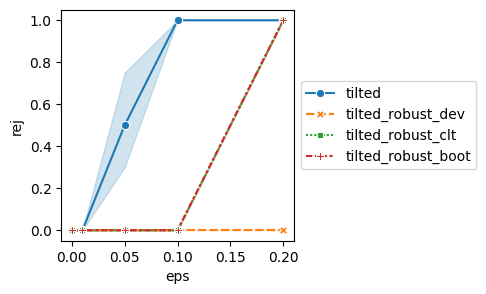

In [281]:
_, ax = plt.subplots(figsize=(3, 3))

res_plot = res_stats
method_list = ["tilted", "tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"]

plot_df = {"eps": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_plot[eps]["tilted"]["nonsq_stat"]
    for m in method_list:
        plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
        plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
        plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
        
        plot_df["rej"] = plot_df["rej"] + res_plot[eps][m]["rej"]
        plot_df["method"] = plot_df["method"] + [m] * len(rr)

plot_df = pd.DataFrame(plot_df)

_ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="method", style="method", markers=True)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

theta_new 0.01


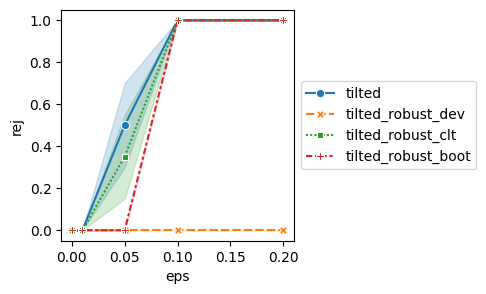

In [282]:
theta_new = 0.01
print("theta_new", theta_new)
# change theta
res_new = copy.deepcopy(res_stats)
for eps in eps_ls:
    res_new[eps] = exp_utils.change_theta(
        res_new[eps], ["tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"], theta_new)


_, ax = plt.subplots(figsize=(3, 3))

res_plot = res_new
method_list = ["tilted", "tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"]

plot_df = {"eps": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_plot[eps]["tilted"]["nonsq_stat"]
    for m in method_list:
        plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
        plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
        plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
        
        plot_df["rej"] = plot_df["rej"] + res_plot[eps][m]["rej"]
        plot_df["method"] = plot_df["method"] + [m] * len(rr)

plot_df = pd.DataFrame(plot_df)

_ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="method", style="method", markers=True)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Optimize

In [2]:
def f(x):
    return (x-2.)**3.

In [3]:
grad_f = jax.grad(f)

In [4]:
grad_f(jnp.array(1.))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(3., dtype=float32, weak_type=True)

In [10]:
init_params = jnp.array(1.)
solver = jaxopt.ScipyMinimize(fun=grad_f, maxiter=100)
res = solver.run(init_params)

In [12]:
res.params

Array(2., dtype=float32)

In [13]:
print(res.params)
print(res.state)

2.0
ScipyMinimizeInfo(fun_val=Array(0., dtype=float32, weak_type=True), success=True, status=0, iter_num=2, hess_inv=Array([[0.16666667]], dtype=float32), num_fun_eval=Array(3, dtype=int32), num_jac_eval=Array(3, dtype=int32), num_hess_eval=Array(0, dtype=int32))
